# Assignment 1

*Part of the course:
Machine Learning (code: INFOB3ML), fall 2022, Utrecht University*

Total points: 10

Deadline: Friday 16 September, 23:59

**Write your names and student numbers here: ___**

Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**

## Linear Regression with Regularisation
In this assignment, you will perform several simulation experiments with linear regression, in order to investigate the effects of regularisation.

Those who followed the course Introduction to Machine Learning will see that this assignment resembles the linear regression assignment from that course. If you didn't take that course, don't worry: everything you need to know about it is also in chapter 1 of the Rogers & Girolami book.

## Overview
### Data generation
Every datapoint $(x,t)$ will be sampled randomly, with both $x$ and $t$ in $\mathbb{R}$. (Note that the book from Introduction to Machine Learning called the output $y$, while this course's book calls it $t$.) The input $x$ is uniformly distributed between $-1$ and $1$.

Once we have our input $x$, we generate our output $t$ according to $t = 1 - \cos(x) + \epsilon$, where $\epsilon$ is normally distributed with expected value = 0 and variance = $\sigma^2$.
All the random numbers should be generated **independently** from one another.

### Regression

We'll implement *regularised* regression, adding a penalty $\lambda \mathbf{w}^T \mathbf{w}$ to our training loss. Linear regression with this form of regularisation penalty is also called *ridge regression*. We are going to try out different values of $\lambda$.

We'll use regression with order five polynomials like in the book. This means that for each weight vector $\mathbf{w}$, our hypothesis is of the form
$$f(x; \mathbf{w}) = \sum_{i=0}^5 w_i x^i.$$

## Your Code

To make it clear what your code is supposed to do and how it should be formatted, we provide you general schema for each to-be-written function. Some functions come with additional hints about useful in-built functions or procedural details. You might write the function's body differently than the hints suggests. That's totally fine as long as the function works as it supposed to work.

Use numpy for functionalities involving vectors and matrices. [Here is a handy guide (in notebook form) that deals with numpy arrays, matrices and number generation.](https://github.com/ageron/handson-ml/blob/master/tools_numpy.ipynb)

### Data generation with noise

**Assignment 1** (1 point)

Write a function `generate_data` you can use to generate a dataset and outputs the pair of vectors `(x,t)`, accepting parameters $N$ and $\sigma^2$. Be sure to check if your normal-distribution-generator needs $\sigma$ (standard deviation) or $\sigma^2$ (variance) as input parameter. Both `x` and `t` should be 1-dimensional numpy arrays, i.e. their shape should be `(N,)`.

In [1]:
import numpy as np
import math
# Some functions you may find useful (here and later):
# np.cos, np.ones, np.random.random_sample, np.random.randn,
# np.linalg.inv, np.hstack, np.matmul (or @), np.dot, math.sqrt.

def generate_data(N, sigma_squared):
    x_vector = (np.random.random_sample((N,)) - 0.5) * 2
    t_vector = []
    index = 0
    sigma = math.sqrt(sigma_squared)
    for index in range(N):
        error = np.random.normal(0.0, sigma)
        t_vector.append(1 - np.cos(x_vector[index]) + error)

        
    return x_vector, np.asarray(t_vector)
    
        
        

In [2]:
# ██████████ TEST ██████████
# (These "TEST" blocks can help you quickly check if there's something obviously wrong with the code you wrote.)
# Setting a seed helps to make the data generation deterministic for comparison reasons
np.random.seed(0)
toy_xs, toy_t = generate_data(3, 0.1)
# Check if the shapes of the output arrays are as specified above:
print(toy_xs.shape)
print(toy_xs)
print(toy_t.shape)
print(toy_t)

(3,)
[0.09762701 0.43037873 0.20552675]
(3,)
[-0.71254663  0.51289628 -0.24544636]


Next, in order to learn 5th-order polynomials, we want to have a function that computes the matrix $\mathbf{X}$. (See equation (1.18) on page 28 of the book for what this matrix should look like.)

**Question 2** (1 point)

(a) When dealing with $N$ data points, what should the size of the $\mathbf{X}$-matrix be? (Give the number or rows and the number of columns.)

*With 5'th order polynomials, the matrix X should be 6xN. 6 columns, N rows.*

(b) Where in the matrix will you find the vector `x_scalars`?

*The x_scalars will be present in the 2nd column.*

(c) Where in the matrix will you find $\mathbf{x}_1$ (the feature vector associated to the first data point)?

*The first datapoint will be in the first row.*

**Assignment 3** (1 point)

Write a function `compute_X_matrix` that takes a numpy array `x_scalars` as produced by your code above, and returns the matrix `X` needed by linear regression with 5th-order polynomials.

In [3]:
def compute_X_matrix(x_scalars):
    x_matrix = []
    N = len(x_scalars)
    for index in range(N):
        x_scalar = x_scalars[index]
        partial_x = [1, x_scalar, x_scalar**2, x_scalar**3,  x_scalar**4,  x_scalar**5] #Miss een beetje bagger dit maar werkt allee met 5th
        x_matrix.append(partial_x)
        
    return np.asmatrix(x_matrix)
        
    

In [4]:
# ██████████ TEST ██████████
toy_X = compute_X_matrix(toy_xs)
print(toy_xs)
print(toy_X)
print(toy_X.shape)

[0.09762701 0.43037873 0.20552675]
[[1.00000000e+00 9.76270079e-02 9.53103266e-03 9.30486201e-04
  9.08405836e-05 8.86849437e-06]
 [1.00000000e+00 4.30378733e-01 1.85225854e-01 7.97172681e-02
  3.43086168e-02 1.47656990e-02]
 [1.00000000e+00 2.05526752e-01 4.22412458e-02 8.68170607e-03
  1.78432285e-03 3.66726080e-04]]
(3, 6)


### Fitting linear regression

**Assignment 4** (1 point)

Write code that fits a regularised linear regression hypothesis to training data, in other words, a function that computes our $\hat{\mathbf{w}}$. Use numpy to carry out the necessary matrix operations to find an analytic solution; don't use linear regression functionality from Python packages for machine learning. In other words, compute $\hat{\mathbf{w}}$ according to the equation (1.21) on page 36 of the book. Give your function a parameter `lamb` which tells it the value of $\lambda$.
   

In [5]:
def fit_ridge(X, t, lamb):
    N = len(X)    
    total = np.linalg.inv(X.T @ X + N * lamb * np.identity(6)) @ X.T @ np.reshape(t, (N,1)) # in een keer, geeft 6x1 terug, lijkt te kloppen
    return total

#Dit is nu complete chaos. Concreet: probleem lijkt te zitten in die (n,) dimensie van t. Als je dit aanpast naar (n,1) werkt het wel


In [6]:
# ██████████ TEST ██████████
# this test uses values for toy_X and toy_t printed above
# You migh need to define these values by hand
# if your "generate_data" returns different data
print(toy_X)
print(toy_t)
print(fit_ridge(toy_X, toy_t, 0.01))
print(fit_ridge(toy_X, toy_t, 100))

[[1.00000000e+00 9.76270079e-02 9.53103266e-03 9.30486201e-04
  9.08405836e-05 8.86849437e-06]
 [1.00000000e+00 4.30378733e-01 1.85225854e-01 7.97172681e-02
  3.43086168e-02 1.47656990e-02]
 [1.00000000e+00 2.05526752e-01 4.22412458e-02 8.68170607e-03
  1.78432285e-03 3.66726080e-04]]
[-0.71254663  0.51289628 -0.24544636]
[[-0.69726571]
 [ 1.88156984]
 [ 1.00802551]
 [ 0.45015441]
 [ 0.19470722]
 [ 0.08376452]]
[[-1.47003611e-03]
 [ 3.38997111e-04]
 [ 2.60495694e-04]
 [ 1.27356278e-04]
 [ 5.71334367e-05]
 [ 2.49870604e-05]]


### Squared loss over the data

The following code (which you don't need to change) evaluates a learned linear regression function $\hat{\mathbf{w}}$ with respect to the data $\mathbf{X}, \mathbf{t}$ using the squared error loss. This Python function can be used to compute training, validation or test loss for $\hat{\mathbf{w}}$, depending of the kind of data passed to it.

In [7]:
def compute_loss(w, X, t):
    N, k = X.shape
    t_hat = X @ w
    t_error = t_hat - t
    sum_of_squared_errors = t_error.T @ t_error
    loss = sum_of_squared_errors / N
    return loss

## Visualising regularisation

Now it's time to do some experiments and look at the results.

First, the function provided below will plot the target function $1 - \cos(x)$, a regression function, and the training data all in one plot. 

In [8]:
import matplotlib.pyplot as plt

def plot_regression_result(xs_train, t_train, w, include_target_function=True):
    xs_plot = np.linspace(-2, 2, 101)
    X_plot = compute_X_matrix(xs_plot)
    if include_target_function:
        plt.plot(xs_plot, 1 - np.cos(xs_plot), c='black') # target 
    plt.scatter(xs_train, t_train, c='blue', marker=".")
    plt.plot(xs_plot, X_plot @ w, c='red')
    plt.ylim(-1, 1.5)
    plt.show()

**Assignment 5** (1 point)

Generate a dataset of $N=15$ data points with noise level $\sigma^2 = 0.1$. (You'll use this dataset in assignments/questions 5 through 7.) For the values of $\lambda$ provided in the code below, fit a regularised regression curve to the data and compute the loss. Display the results in a plot.

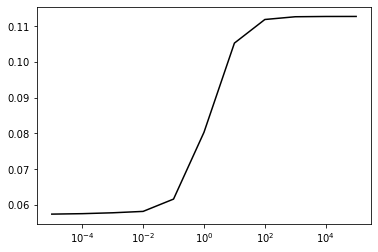

In [9]:
lambdas = 10 ** np.linspace(-5, 5, 11)
losses = np.zeros_like(lambdas) 

np.random.seed(0)

# Your code here
x_vector, t_vector = generate_data(15, 0.1)
x_matrix = compute_X_matrix(x_vector)

t_reshaped = np.reshape(t_vector, (15,1))

for index in range(len(lambdas)):
    weights = fit_ridge(x_matrix, t_vector, lambdas[index])
    loss = compute_loss(weights, x_matrix, t_reshaped)
    losses[index] = loss
    
    
plt.semilogx(lambdas, losses, c='black') # target 
plt.show()

**Question 6** (1 point) Your plot should show that as $\lambda$ gets larger, the loss also gets larger. Explain why this is to be expected.

$\lambda$ is the amount of regularisation. When $\lambda$ gets larger, the function becomes even more smoooth, this gives less overfitting, meaning that the function gets further away from the target function. This increases the loss. 

**Assignment/Question 7** (1 point)

Using the same data, answer the following questions:

For what values of $\lambda > 0$ do you clearly see overfitting? For what values of $\lambda$ do you see underfitting? To support your answer, include plots for some values of $\lambda$, and point out what features of those plots tell you that over-/underfitting is going on.

Value of lambda: 1e-05


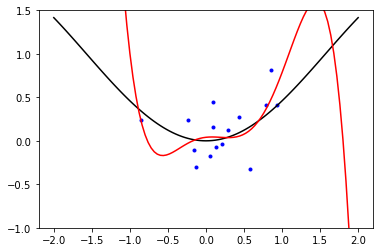

Value of lambda: 0.0001


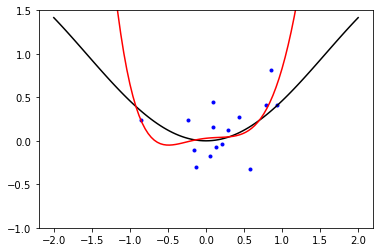

Value of lambda: 0.001


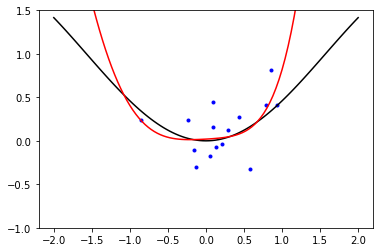

Value of lambda: 0.01


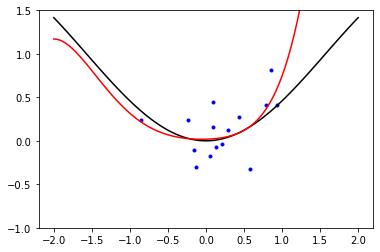

Value of lambda: 0.1


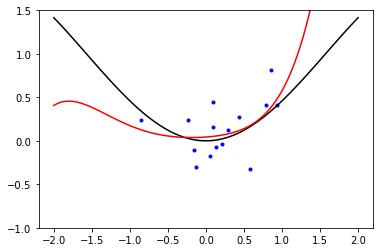

Value of lambda: 1.0


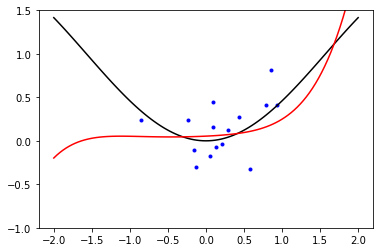

Value of lambda: 10.0


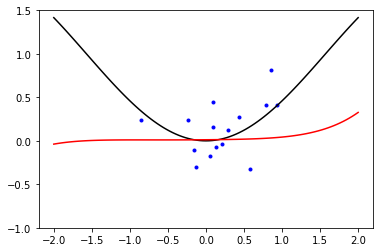

Value of lambda: 100.0


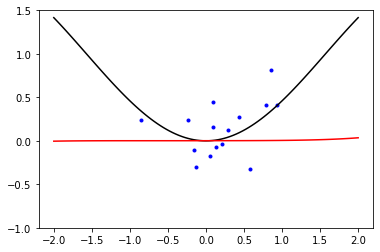

Value of lambda: 1000.0


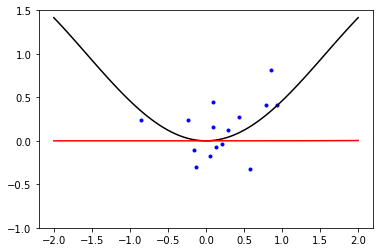

Value of lambda: 10000.0


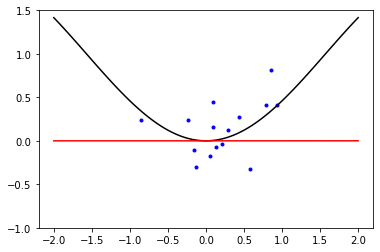

Value of lambda: 100000.0


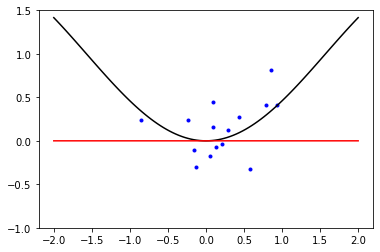

In [10]:
# Your code here
#x_vector, t_vector = generate_data(15, 0)

for index in range(len(lambdas)):
    
    weights = fit_ridge(x_matrix, t_vector, lambdas[index])
    print("Value of lambda:", lambdas[index])
    plot_regression_result(x_vector, t_vector, weights, True)


For the value of lambda of 1e-05 the function is clearly overfitted. For 0.0001 the function also overfits. 
For values in between 0.001 and 0.1 the function is balanced, and with all values above the function becomes underfitted. 

## Cross-validation

To find a good value of $\lambda$, a variety of techniques exist. One that obviously does *not* work is to look at the training loss as a function of $\lambda$ (like you plotted above): that would always suggest to make $\lambda$ as small as possible! A versatile technique that you've already seen in an earlier course (or in section 1.5 of the book) is **cross-validation**.

**Assignment 8** (1 point)

Write some code to do the following: sample a new dataset of $N = 50$ data points and $\sigma^2=0.1$. (You'll use this dataset for all the remaining assignments and questions.) Write a function that, given data and value of $\lambda$, computes the leave-one-out cross-validation (LOOCV) loss, as explained in section 1.5.2 of the book. Then make a plot similar to what we did in assignment 5 for the training loss, but this time displaying the LOOCV loss as a function of $\lambda$.

Note that the third argument, `fitting_function`, should be the name of a function that `LOOCV` can call to compute `w`. If `fit_ridge` is passed, your previously written function will be used. But later, you'll call it with a different fitting function.

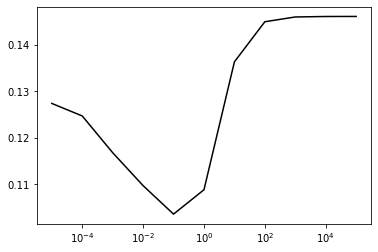

In [11]:
def LOOCV(X, t, fitting_function, lamb):
    N, k = X.shape
    X_temp = X
    t_temp = t
    sum_of_losses = 0.0
    for leave_out in range(N):
        X = X_temp
        t = t_temp
        leave_out_datapoint = X[leave_out]
        X = np.delete(X, leave_out, axis = 0)
        
        
        leave_out_t = t[leave_out]
        t = np.delete(t, leave_out, axis = 0)
        
   #     if(fitting_function == "fit_ridge"):
        weights = fitting_function(X, t, lamb)

        loss = compute_loss(weights, leave_out_datapoint, leave_out_t)
        sum_of_losses += loss
        
 #       print(leave_out_datapoint)
 #       print(loss)
        
        
    return sum_of_losses / N

losses = np.zeros_like(lambdas) 

x_vector, t_vector = generate_data(50, 0.1)
x_matrix = compute_X_matrix(x_vector)
t_reshaped = np.reshape(t_vector, (50,1))


for index in range(len(lambdas)):
    loss = LOOCV(x_matrix, t_reshaped, fit_ridge, lambdas[index])
    losses[index] = loss

plt.semilogx(lambdas, losses, c='black')
plt.show()

# Your code here to sample a larger dataset, and to make the plot of the LOOCV loss for each lambda


**Question 9** (0.5 points): What value of $\lambda$ does LOOCV point you to? Look at a plot of the resulting regression function. Does it look reasonable?

The graph is the lowerst for lambda = 0.1. When looking at the graphs from question 7, this looks like a reasonable result. 

## Lasso regression

As the book mentions, when doing regularisation, using the squares of $\mathbf{w}$ as a penalty is just one of many possibilities. It has the advantage of having an analytical solution. But other options exist that may have other advantages, and while they may not be analytically computable, still there exist efficient algorithms for working with them. A particularly popular one is to use the sum of absolute values of $\mathbf{w}$ as a penalty: we will find the $\mathbf{w}$ that minimizes
$$\mathcal{L}' = \mathcal{L} + \lambda \sum_i \lvert w_i \rvert.$$
This is called the 'lasso' (which is an acronym for 'least absolute shrinkage and selection operator', but of course most people just remember the acronym).

There is no direct formula for computing the $\mathbf{w}$ that minimizes $\mathcal{L}'$. The next alternative would be to use (stochastic) gradient descent. Unfortunately, that also doesn't work very nicely here, because as a function of $\mathbf{w}$, $\mathcal{L}'$ is not differentiable wherever $\mathbf{w}$ has at least one entry equal to zero. But variants of gradient descent have been developed that can deal with this problem (such as [proximal gradient descent](https://en.wikipedia.org/wiki/Proximal_gradient_method)), and implementations are readily available. The fitting function provided below uses such an implementation.

In [12]:
from sklearn.linear_model import Lasso

def fit_lasso(X, t, lamb):
    clf = Lasso(lamb, fit_intercept=False, max_iter=100000)
    clf.fit(X, t)
    return clf.coef_

**Assignment 10** (0.5 point) Again plot the LOOCV losses as a function of $\lambda$, but this time for lasso regression instead of ridge regression. Read off the values of $\lambda$ that minimizes the LOOCV loss, and display the regression function for that $\lambda$ in a separate plot.

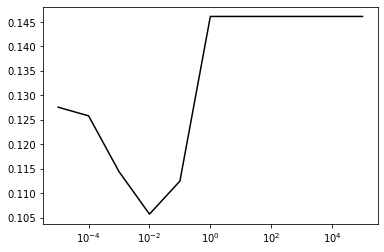

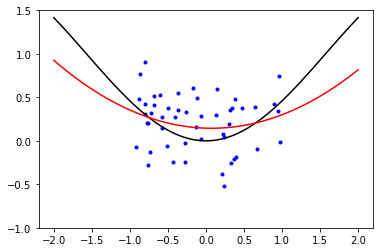

In [13]:
for index in range(len(lambdas)):
    loss = LOOCV(x_matrix, t_reshaped, fit_lasso, lambdas[index])
    losses[index] = loss

plt.semilogx(lambdas, losses, c='black')
plt.show()

weights = fit_lasso(x_matrix, t_vector, 0.01)
weights = np.reshape(weights, (len(weights), 1))

plot_regression_result(x_vector, t_reshaped, weights, True)


An important property of lasso regularisation is its tendency to make some weigths exactly equal to 0. (Well, mathematically that's true, but you should never rely on things being *exactly* equal when a numerical algorithm is involved. Instead, check whether the difference between them is very small, say less than `1e-9`.)

**Assignment 11** (0.5 points)

What is the smallest $\lambda$ in `lambdas` for which you observe this happening for some $w_i$? For that $\lambda$, make a plot where $w_i$ varies along the horizontal axis. On the vertical axis, plot the regularised loss $\mathcal{L}'$ of the weight vector, with all entries other than $w_i$ kept equal to the optimal lasso solution. Choose the range of $w_i$-values small enough that you see a nondifferentiability in the graph.

1e-05 [ 0.14474119 -0.31599769  0.13548333  0.95351854  0.16367106 -0.7254811 ]
0.0001 [ 0.14474295 -0.2716148   0.12614649  0.71774413  0.15870596 -0.50168299]
0.001 [ 0.14182641 -0.13923002  0.13848698  0.1410033   0.10921842  0.        ]
0.001 5
[0, 0.0001, 0.001, 0.01, 0.1, 1]
[0.09127137142330154, 0.0912713573291338, 0.09127130313644796, 0.09127795403714249, 0.09206374579937984, 0.1718499389509753]


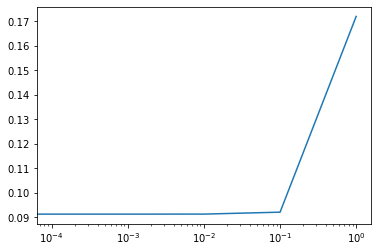

In [36]:
def compute_reg_loss(loss, lamb, weights):
    sum = 0
    for weight in weights:
        sum += abs(weight)
    regloss = loss + lamb * sum
    return regloss
    

optimal_lamb = 0
weight_index = 0
for lamb in lambdas:
    weights = fit_lasso(x_matrix, t_vector, lamb)
    print(lamb, weights)
    for index, wi in enumerate(weights):
        if(abs(wi) < 1e-9):
            optimal_lamb = lamb
            weight_index = index
            optimal_weights = weights
            break
    if (optimal_lamb != 0):
        break
print(optimal_lamb, index)

w_var_list = [0, 0.0001, 0.001, 0.01, 0.1, 1]
regloss_list = []
for w_var in w_var_list:
    temp_weights = optimal_weights
    temp_weights[weight_index] = w_var
    
    temp_weights = np.reshape(temp_weights, (len(temp_weights), 1))
    
    loss = compute_loss(temp_weights, x_matrix, t_reshaped)
    regloss = compute_reg_loss(loss, optimal_lamb, temp_weights)
    regloss_list.append(regloss.item(0))
    


            
print(w_var_list)
print(regloss_list)

plt.semilogx(w_var_list, regloss_list)
plt.show()

    

**Question 12** (0.5 points): Use this graph to explain why lasso regression has a tendency to make some weights equal to 0.

The graph shows that values that are very close to 0, are best at minimizing the regularised loss, without making the weight exactly 0. LASSO puts up soft constraints that penalize the loss when weight values are high, so they must be very close to 0.

    
---

<br>
<br>

**Remember: Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**